# COPERNICUS MARINE DATASET - THE NORTH SEA

# Feature importance analysis (using XGBoost)

https://help.marine.copernicus.eu/en/articles/8283072-copernicus-marine-toolbox-api-subset

https://pypi.org/project/copernicusmarine/

In [24]:
import copernicusmarine
import os
import pandas as pd
from tqdm import tqdm
import numpy as np
#import shap
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
import shap
from sklearn.inspection import permutation_importance
import seaborn as sns


# To avoid warning messages
import warnings
warnings.filterwarnings('ignore')

# Import Garbage Collector - we will need it a lot here, since we are dealing with huge files and might have memory issues!
import gc

In [2]:
# You need to log in a Copernicus Marine account to access the data.
copernicusmarine.login()
# Copernicus username and password.

username:password:File C:\Users\fbale\.copernicusmarine\.copernicusmarine-credentials already exists, overwrite it ? [y/N]:

INFO - 2024-08-14T10:38:35Z - Credentials file stored in C:\Users\fbale\.copernicusmarine\.copernicusmarine-credentials.


True

# Import datasets as pandas dataframes (skip this if you already have merged_df.csv)

(Based on Kshitiz's code)

In [ ]:
NORTH_SEA_REGION_lat = [50, 62]
NORTH_SEA_REGION_lon = [-6, 12]
TIMEFRAME = ["1997-01-01T00:00:00", "2023-01-01T00:00:00"]
DEPTH = [0.49402499198913574, 5727.9169921875]

TIMEFRAMES_SST = [["1997-01-01T00:00:00", "2002-12-01T00:00:00"], ["2002-12-02T00:00:00", "2007-12-01T00:00:00"], ["2007-12-02T00:00:00", "2012-12-01T00:00:00"],
                  ["2012-12-02T00:00:00", "2017-12-01T00:00:00"], ["2017-12-02T00:00:00", "2023-01-01T00:00:00"]]

SST_COUNTER = 0

CURR_DIR = os.getcwd()
DATASETS_DIR = CURR_DIR + "\\datasets_csv"
os.makedirs(DATASETS_DIR, exist_ok = True)

In [ ]:
def get_and_polish_dataset(dataset_id, variables, output_name, SST_COUNTER):

    if output_name == 'bathy':
        depth_ = DEPTH
    else:
        depth_ = [None, None]


    if (not output_name == 'bathy') and (not output_name == 'sst'):
        time_ = TIMEFRAME
    elif output_name == 'sst':
        time_ = TIMEFRAMES_SST[SST_COUNTER]
        output_name = output_name + '_' + str(SST_COUNTER)
    else:
        time_ = [None, None]

    data_request = {
    "dataset_id" : dataset_id,
    "variables" : variables,
    "longitude" : NORTH_SEA_REGION_lon, 
    "latitude" : NORTH_SEA_REGION_lat,
    "time" : time_,
    "depth": depth_
    } 

    if not output_name == 'bathy':
        df = copernicusmarine.read_dataframe(dataset_id=data_request["dataset_id"],
                                        variables=data_request["variables"],
                                        minimum_longitude=data_request["longitude"][0],
                                        maximum_longitude=data_request["longitude"][1],
                                        minimum_latitude=data_request["latitude"][0],
                                        maximum_latitude=data_request["latitude"][1],
                                        minimum_depth=data_request["depth"][0],
                                        maximum_depth=data_request["depth"][1],
                                        start_datetime=data_request["time"][0],
                                        end_datetime=data_request["time"][1]
                                        )
    else:
         df = copernicusmarine.read_dataframe(dataset_id=data_request["dataset_id"],
                                        variables=data_request["variables"],
                                        minimum_longitude=data_request["longitude"][0],
                                        maximum_longitude=data_request["longitude"][1],
                                        minimum_latitude=data_request["latitude"][0],
                                        maximum_latitude=data_request["latitude"][1],
                                        minimum_depth=data_request["depth"][0],
                                        maximum_depth=data_request["depth"][1]
                                        )

    df = df.dropna()


    # function to coarse grain the data and make resolution same as Pisces data
    def coarse_grain(df, features, output_name):
        """
            Parameters
            ----------
            df: pandas dataframe containing the data accessed from copernicus mariner
            features: name of the features in the dataframe

            Output
            ------
            a pandas dataframe with feature values for 0.25 deg x 0.25 deg resolution 

            """
        
        df["0_1"] = df["latitude"].to_numpy() - np.floor(df["latitude"])
        conditions = [df["0_1"] < 0.25,
                        (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
                        (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
                        (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
        outputs = [0, 0.25, 0.5, 0.75]
        df['latitude'] = np.floor(df["latitude"]) + np.select(conditions, outputs)
        df = df.drop(columns=["0_1"])

        df["0_1"] = df["longitude"].to_numpy() - np.floor(df["longitude"])
        # if not redefined then conditions is based on latitude
        conditions = [df["0_1"] < 0.25,
                    (df["0_1"] >= 0.25)  & (df["0_1"] < 0.5),
                    (df["0_1"] >= 0.5)  & (df["0_1"] < 0.75),
                    (df["0_1"] >= 0.75)  & (df["0_1"] < 1)]
        df['longitude'] = np.floor(df["longitude"]) + np.select(conditions, outputs)
        df = df.drop(columns=["0_1"])

        if not output_name == 'bathy': 
            return df.groupby(["time", "latitude", "longitude"])[features].mean()
        else:
            return df.groupby(["latitude", "longitude"])[features].mean()
    
    if not output_name == 'pisces':
        df = df.reset_index()
        if not output_name == 'bathy':
            df_cg = coarse_grain(df, df.columns[3:].tolist(), output_name)
        else:
            df_cg = coarse_grain(df, df.columns[2:].tolist(), output_name)
    else:
        # remove depth as index
        df = df.reset_index(level=["depth"])
        # average across the depth for each (time, latitude, longitude)
        df_cg = df.reset_index().groupby(["time","latitude","longitude"]).mean()
        df_cg = df_cg.drop(columns=["depth"])


    # remove time and just have month and year
    df_cg = df_cg.reset_index()

    if not output_name == 'bathy':
        # from https://stackoverflow.com/questions/53509168/extract-year-month-and-day-from-datetime64ns-utc-python
        datetimes = pd.to_datetime(df_cg['time'])
        df_cg['day'] = datetimes.dt.day
        df_cg['month'] = datetimes.dt.month
        df_cg['year'] = datetimes.dt.year

        # remove the time column
        df_cg = df_cg.drop(columns=["time"])
        df_cg = df_cg.set_index(["year","month","day","latitude","longitude"])
        df_cg = df_cg.groupby(["year","month","latitude","longitude"]).mean()
        try:
             df_cg = df_cg.drop(columns = ["day"])
        except: 
            pass

    df_cg.to_csv(f"{DATASETS_DIR}/{output_name}.csv")

    del df, df_cg
    gc.collect()

    return SST_COUNTER

In [ ]:
bathy_info = { 'dataset_id': 'cmems_mod_glo_phy_my_0.083deg_static',
               'variables': ['deptho'],
               'output_name' : 'bathy'}

carbon_info = { 'dataset_id': 'dataset-carbon-rep-monthly',
               'variables': ["fgco2", "omega_ar", "omega_ca", "ph", "spco2", "talk", "tco2"],
               'output_name' : 'carbon'}

chlorophyll_info = { 'dataset_id': 'cmems_obs-oc_glo_bgc-plankton_my_l4-multi-4km_P1M',
               'variables': ["CHL"],
               'output_name' : 'chlorophyll'}

pisces_info = { 'dataset_id': 'cmems_mod_glo_bgc_my_0.25deg_P1M-m',
               'variables': ["fe", "no3", "o2", "po4", "si"],
               'output_name' : 'pisces'}

sssd_info = { 'dataset_id': 'cmems_obs-mob_glo_phy-sss_my_multi_P1M',
               'variables': ["sos","dos"],
               'output_name' : 'sssd'}

sst_info = { 'dataset_id': 'METOFFICE-GLO-SST-L4-REP-OBS-SST',
               'variables': ["analysed_sst"],
               'output_name' : 'sst'}

In [ ]:
dataset_names = [bathy_info, carbon_info, chlorophyll_info, pisces_info, sst_info]
# For sssd, use Kshitiz's notebook directly.

In [ ]:
for name in tqdm(dataset_names):
    if not name['output_name'] == 'sst':
        get_and_polish_dataset(name['dataset_id'], name['variables'], name['output_name'], SST_COUNTER)
    else:
        for _ in range(len(TIMEFRAMES_SST)):
            get_and_polish_dataset(name['dataset_id'], name['variables'], name['output_name'], SST_COUNTER)
            SST_COUNTER += 1


### Merge datasets together

In [ ]:
df_sst = [pd.read_csv(f"{DATASETS_DIR}/sst_{i}.csv") for i in range(len(TIMEFRAMES_SST))]
df_sst = pd.concat(df_sst)

In [ ]:
df_sst.head()

,year,month,latitude,longitude,analysed_sst
0,1997,1,50.0,-6.00,282.574342
1,1997,1,50.0,-5.75,282.242026
2,1997,1,50.0,-5.50,281.981512
3,1997,1,50.0,-5.25,282.242816
4,1997,1,50.0,-5.00,282.143143


In [ ]:
all_df = []
for df in os.listdir(DATASETS_DIR):
    if not df.startswith('bathy'):
        all_df.append(pd.read_csv(f"{DATASETS_DIR}/{df}").set_index(["year", "month", "latitude", "longitude"]))
    else:
        all_df.append(pd.read_csv(f"{DATASETS_DIR}/{df}").set_index(["latitude", "longitude"]))
[len(x) for x in all_df]

[2246, 502181, 632471, 629928, 571372, 726150]

In [ ]:
# Some datasets still have an unnamed column corresponding to an indexing column that we need to drop
cleaned_all_df = []
for df in all_df:
    try:
        cleaned_all_df.append(df.drop(columns=['Unnamed: 0']))
    except:
        cleaned_all_df.append(df)

In [ ]:
merged_df = cleaned_all_df[0]
for df in cleaned_all_df[1:]:
    merged_df = merged_df.join(df, how = 'inner')

In [ ]:
merged_df.head(5)

deptho     fgco2  omega_ar  omega_ca  \
latitude longitude year month                                            
50.0     -6.0      1997 9      60.526028  0.227585  2.719359  4.230194   
                        10     60.526028 -0.619145  2.628897  4.090527   
                        11     60.526028 -1.041761  2.493900  3.892442   
                        12     60.526028 -1.172034  2.322141  3.636425   
                   1998 1      60.526028 -0.549181  2.262097  3.549769   

                                     ph      spco2       talk       tco2  \
latitude longitude year month                                              
50.0     -6.0      1997 9      8.102758  350.64914  2316.5593  2066.4870   
                        10     8.086442  366.88492  2319.2300  2078.1743   
                        11     8.083461  370.13690  2323.9930  2094.8590   
                        12     8.076384  375.84900  2315.3400  2102.7578   
                   1998 1      8.081886  370.24802  2320.5670  2112.9500   

                                    CHL        fe       no3         o2  \
latitude longitude year month                                            
50.0     -6.0      1997 9      1.691628  0.002023  0.318225  258.28275   
                        10     2.681175  0.002226  0.158724  257.91226   
                        11     0.683594  0.001937  0.333718  261.03170   
                        12     0.825124  0.001995  0.621712  270.01602   
                   1998 1      0.812032  0.001657  1.309169  279.46298   

                                    po4        si        sos        dos  \
latitude longitude year month                                             
50.0     -6.0      1997 9      0.057344  3.344577  35.029587  1025.7375   
                        10     0.033671  2.794624  35.072044  1025.9875   
                        11     0.045267  2.920304  35.213120  1026.4350   
                        12     0.081860  3.424009  35.054203  1026.6138   
                   1998 1      0.149281  4.007182  35.065900  1026.8528   

                               analysed_sst  
latitude longitude year month                
50.0     -6.0      1997 9        288.622194  
                        10       288.415013  
                        11       286.853234  
                        12       285.310187  
                   1998 1        284.068742

In [ ]:
len(merged_df)

426062

In [ ]:
merged_df.to_csv(f"{DATASETS_DIR}/merged_df.csv")

In [ ]:
del cleaned_all_df, all_df, df_sst
gc.collect()

28

# Retrieve merged dataframe (if you already had created merged_df.csv)

In [3]:
CURR_DIR = os.getcwd()
DATASETS_DIR = CURR_DIR + "\\datasets_csv"

In [5]:
merged_df = pd.read_csv(f"{DATASETS_DIR}\merged_df.csv")
merged_df.head()

,latitude,longitude,year,month,deptho,fgco2,omega_ar,omega_ca,ph,spco2,...,tco2,CHL,fe,no3,o2,po4,si,sos,dos,analysed_sst
0,50.0,-6.0,1997,9,60.526028,0.227585,2.719359,4.230194,8.102758,350.64914,...,2066.4870,1.691628,0.002023,0.318225,258.28275,0.057344,3.344577,35.029587,1025.7375,288.622194
1,50.0,-6.0,1997,10,60.526028,-0.619145,2.628897,4.090527,8.086442,366.88492,...,2078.1743,2.681175,0.002226,0.158724,257.91226,0.033671,2.794624,35.072044,1025.9875,288.415013
2,50.0,-6.0,1997,11,60.526028,-1.041761,2.493900,3.892442,8.083461,370.13690,...,2094.8590,0.683594,0.001937,0.333718,261.03170,0.045267,2.920304,35.213120,1026.4350,286.853234
3,50.0,-6.0,1997,12,60.526028,-1.172034,2.322141,3.636425,8.076384,375.84900,...,2102.7578,0.825124,0.001995,0.621712,270.01602,0.081860,3.424009,35.054203,1026.6138,285.310187
4,50.0,-6.0,1998,1,60.526028,-0.549181,2.262097,3.549769,8.081886,370.24802,...,2112.9500,0.812032,0.001657,1.309169,279.46298,0.149281,4.007182,35.065900,1026.8528,284.068742


# Split data into train, val, test sets

In [6]:
# Extract feature and target arrays
X = merged_df.drop('CHL', axis = 1)
y = merged_df[['CHL']]
#X = X.drop('time', axis = 1)
#X = X.drop('latitude', axis = 1)
#X = X.drop('longitude', axis = 1)

del merged_df
gc.collect()

0

In [7]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1729)
X_train_train, X_train_test, y_train_train, y_train_test = train_test_split(X_train, y_train, random_state = 1729)

del X_train, y_train
gc.collect()

0

# Grid search for XGBoost Regression

This can take quite long (about 100-120 mins) depending on the parameters

In [23]:
grid_model = XGBRegressor(n_estimators = 1000, 
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.9,  # Subsample ratio of the training instances
                          colsample_bytree = 0.8, 
                          device = 'cuda')
param_grid = {
    'max_depth': [5, 7, 9],
    'learning_rate': [0.1, 0.01, 0.001],
    'n_estimators': [1000, 2000, 4000]
}

# Create a GridSearchCV object
grid_search = GridSearchCV(estimator = grid_model,
                           param_grid = param_grid,
                           cv = 5,
                           scoring = 'neg_mean_squared_error'

)

# Fit the grid search to the training data
grid_search.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)], verbose = False)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Parameters: {best_params}")

# Create a new model with the best parameters
best_model = XGBRegressor(**best_params)

# Train the best model
best_model.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)], verbose = False)

# Make predictions on the test set
y_pred_best = best_model.predict(X_train_test)

# Evaluate the best model
mse_best = mean_squared_error(y_pred = y_pred_best, y_true = y_train_test)
print(f"MSE with Best Parameters: {mse_best:.5f}")
print(f"RMSE with Best Parameters: {np.sqrt(mse_best):.5f}")

KeyboardInterrupt: 

### Results after XGBoost grid search:

Best Parameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 4000}  <br> 
MSE with Best Parameters: 0.16149  <br> 
RMSE with Best Parameters: 0.40186  <br> 

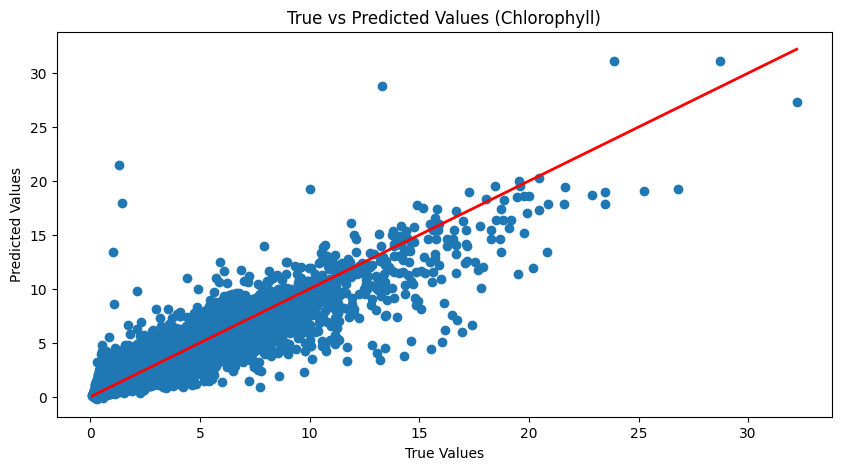

In [25]:
predictions = best_model.predict(X_test)
plt.figure(figsize=(10, 5))
plt.scatter(y_test, predictions)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red',  linewidth=2)
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted Values (Chlorophyll)')
plt.show()

# XGBoost best model

After messing around a bit with grid search and just manual tuning, the best I can do is an RMSE of 0.39288 with these parameters:

XGBRegressor(n_estimators = 20000, 
                          learning_rate = 0.1,
                          max_depth = 7,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.9,  # Subsample ratio of the training instances
                          colsample_bytree = 0.8, 
                          device = 'cuda')

In [9]:
xgb_best_model = XGBRegressor(n_estimators = 20000, 
                          learning_rate = 0.1,
                          max_depth = 7,
                          verbosity = 0, 
                          random_state = 1729, 
                          early_stopping_rounds = 50,  
                          subsample = 0.9,  # Subsample ratio of the training instances
                          colsample_bytree = 0.8, 
                          device = 'cuda')
xgb_best_model.fit(X_train_train, y_train_train, eval_set = [(X_train_train, y_train_train), (X_train_test, y_train_test)], verbose = False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device='cuda', early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=7, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=20000, n_jobs=None,
             num_parallel_tree=None, random_state=1729, ...)

In [10]:
xgb_best_model.save_model("xgb_best_search_grid_model_merged_df_north_sea.json")

# Set up folder for storing the various feature importance plots for XGBoost

In [11]:
CURR_DIR = os.getcwd()

DATASET_NAME = "best_xgboost_merged_df_north_sea"

feat_imp_plots_path = CURR_DIR + f"\\feat_imp_plots_{DATASET_NAME}\\"
if not os.path.exists(feat_imp_plots_path):
    os.mkdir(feat_imp_plots_path)

shap_plots_path = CURR_DIR + f"\\shap_plots_{DATASET_NAME}\\"
if not os.path.exists(shap_plots_path):
    os.mkdir(shap_plots_path)

permutation_imp_plots_path = CURR_DIR + f"\\permutation_imp_plots_{DATASET_NAME}\\"
if not os.path.exists(permutation_imp_plots_path):
    os.mkdir(permutation_imp_plots_path)

# Feature importance: WEIGHT, GAIN, COVER

For XGBoost, we are consider the following three feature importance types: WEIGHT, GAIN, and COVER. For more explanation, see  https://towardsdatascience.com/be-careful-when-interpreting-your-features-importance-in-xgboost-6e16132588e7 .
We are going to select the features from the training set (and not the whole set); see e.g. https://stackoverflow.com/questions/56308116/should-feature-selection-be-done-before-train-test-split-or-after


In [64]:
def create_feature_importance_type_df(model, FEATURE_CONSIDERED):
    list_feat = list(model.get_booster().get_score(importance_type = FEATURE_CONSIDERED).items())
    feat_df = pd.DataFrame(list_feat, columns=['feature',f'importance ({FEATURE_CONSIDERED})']).sort_values(f'importance ({FEATURE_CONSIDERED})', ascending = False)
    total = feat_df[f"importance ({FEATURE_CONSIDERED})"].sum()
    feat_df["proportion"] = feat_df[f"importance ({FEATURE_CONSIDERED})"].div(total)
    gc.collect()
    return feat_df, list_feat

In [65]:
def plot_feature_importance(model, FEATURE_CONSIDERED, COLOUR, save_plot_path):

    df, _ = create_feature_importance_type_df(model, FEATURE_CONSIDERED)


    df = df.set_index('feature').sort_values('proportion')
    top_features = df.index.to_list() # The order right now is revers [fifth, fourth, ..., second, first]
    top_features.reverse()

    # Build horizontal bar char
    ax = df.plot.barh(color=COLOUR, alpha=0.5, grid=True, legend=False, title=f'Feature importance ({FEATURE_CONSIDERED})', figsize=(15, 5))

    # Annotate bar chart, adapted from this SO answer:
    # https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots
    for p, value in zip(ax.patches, df['proportion']):
        ax.annotate(round(value, 2), (p.get_width() * 1.005, p.get_y() * 1.005))
    
    plt.savefig(save_plot_path + f"\\plot_feat_importance_{FEATURE_CONSIDERED}.png")

    gc.collect()
    return top_features

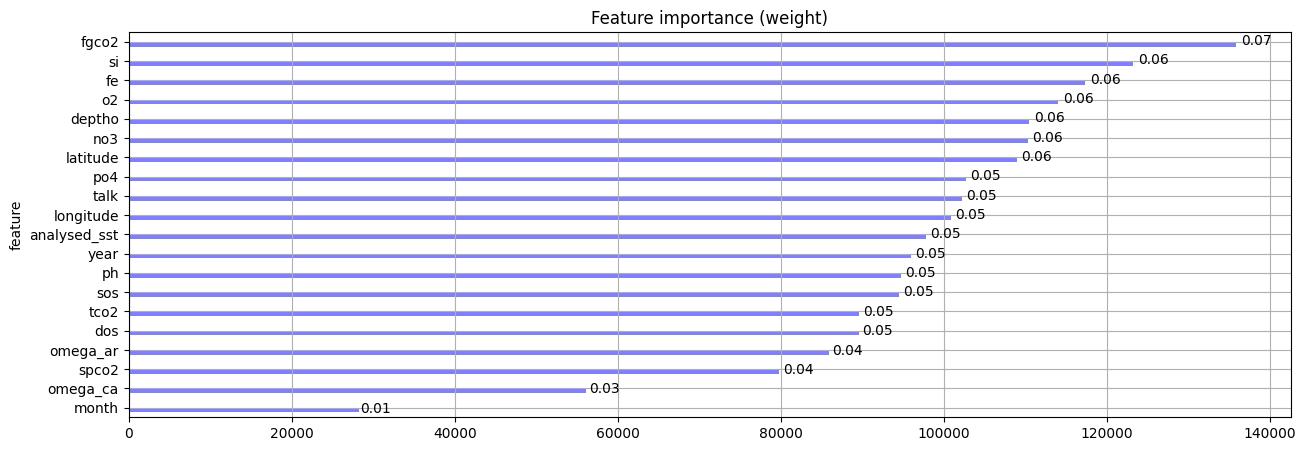

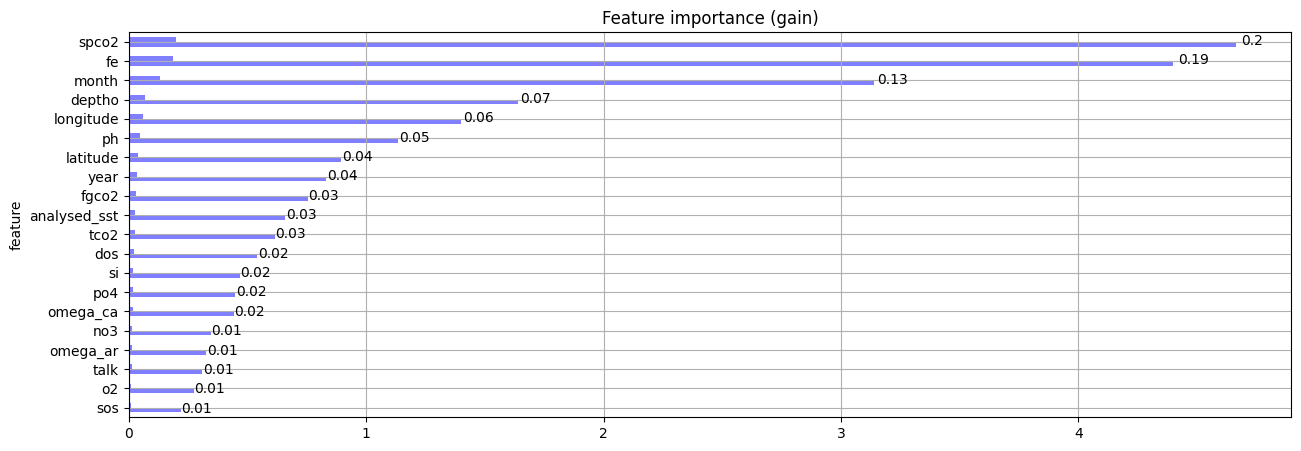

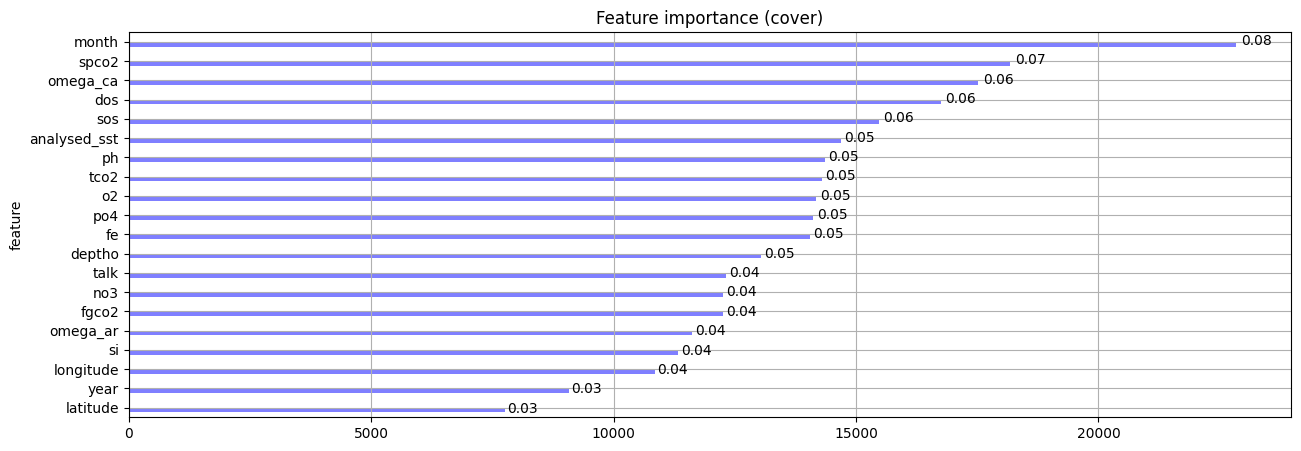

In [66]:
FEAT_IMP_TYPES = ["weight", "gain", "cover"]
# Remember the top features for each of WEIGHT, GAIN, COVER
top_features = []

for feat_imp_type in FEAT_IMP_TYPES:
    top = plot_feature_importance(xgb_best_model, feat_imp_type, "blue", feat_imp_plots_path)
    top_features.append([feat_imp_type, top])
    gc.collect()

# Feature importance: SHAP

In [15]:
explainer = shap.TreeExplainer(xgb_best_model, feature_perturbation= 'tree_path_dependent')
shap_values = explainer.shap_values(X_train_test)
gc.collect()

45

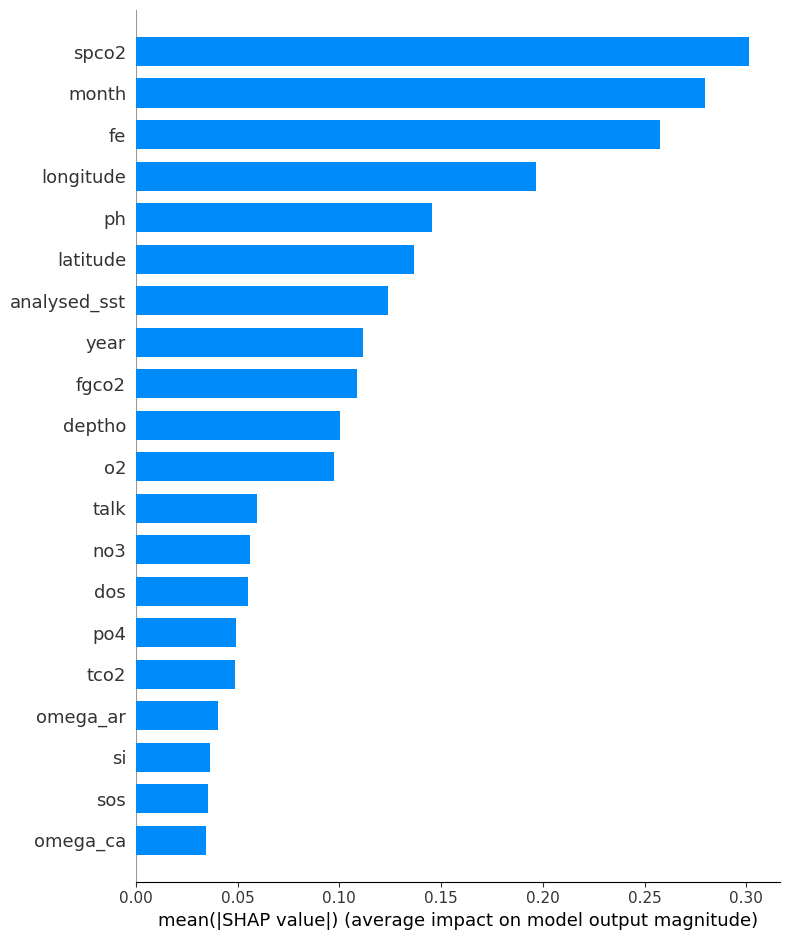

In [16]:
shap.summary_plot(shap_values, X_train_test, plot_type = "bar", show = False)
plt.savefig(shap_plots_path +  "\\shap_bar_plot.png")
plt.show()

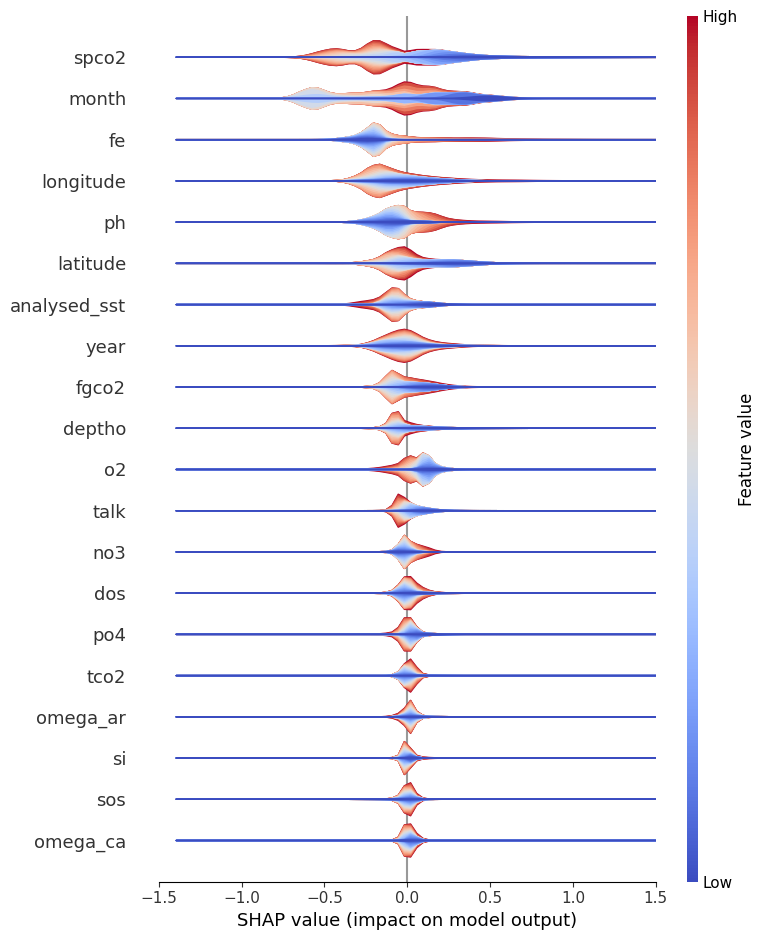

In [20]:
feat_names = list(X_train_test.columns)
shap.summary_plot(shap_values, X_train_test, feature_names = feat_names, plot_type = "layered_violin", show = False)
#https://shap.readthedocs.io/en/latest/example_notebooks/api_examples/plots/violin.html
ax = plt.gca()
ax.set_xlim(-1.5, 1.5)
plt.savefig(shap_plots_path + "\\shap_layered_violin_plot.png")
plt.show()

In [21]:
gc.collect()

0

#### Plot shap dependency plots

In [22]:
# Plot the graph shap_values vs actual values
# Consider the top k features that might interact with the selected feature, and draw plots
def plot_shap_dependency_top_k(shap_values, X, FEATURE, k, save_plots, out_save_path):
    inds = shap.approximate_interactions(FEATURE, shap_values, X)
    # make plots colored by each of the top three possible interacting features
    for i in range(k):
        shap.dependence_plot(FEATURE, shap_values, X, interaction_index = inds[i], show = False)
        if save_plots:
            plt.savefig(out_save_path + f'\\shap_dependency_plot_{FEATURE}_{i}.png')
        plt.show()
        gc.collect()

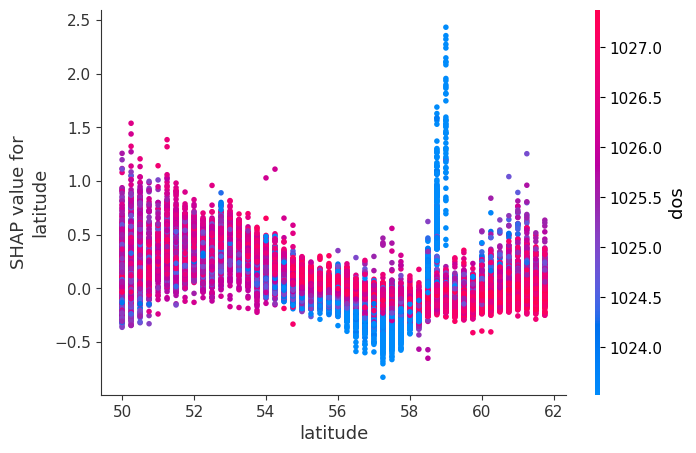

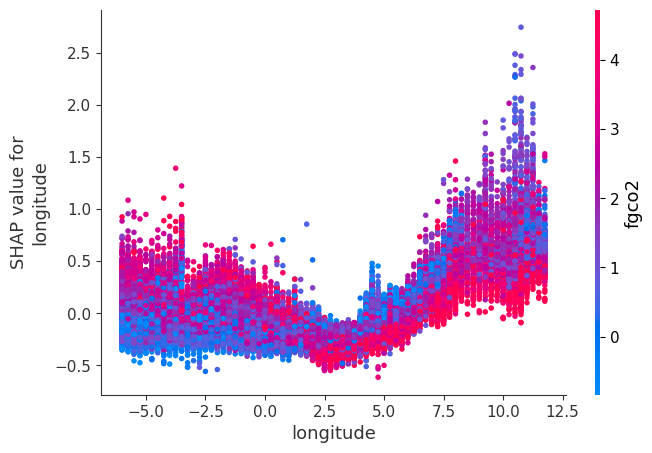

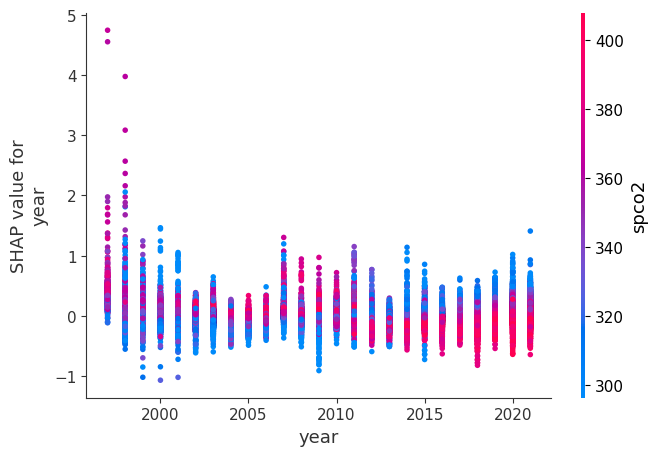

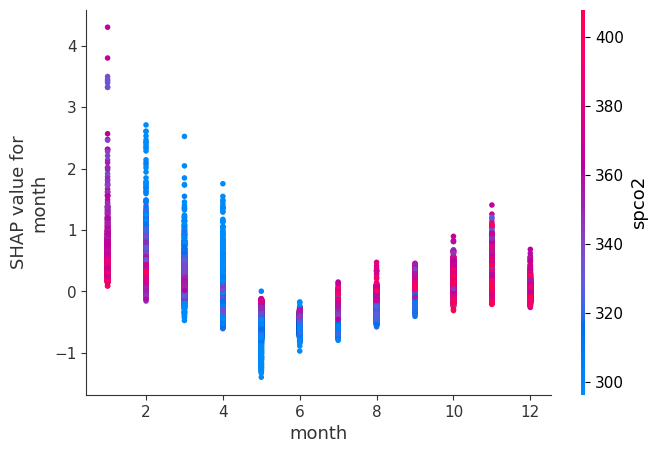

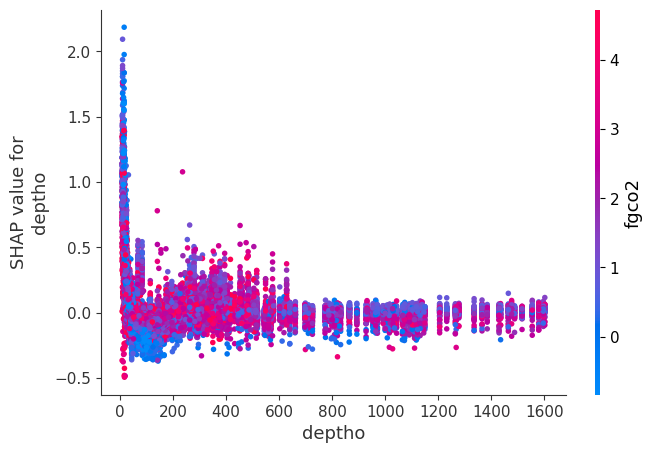

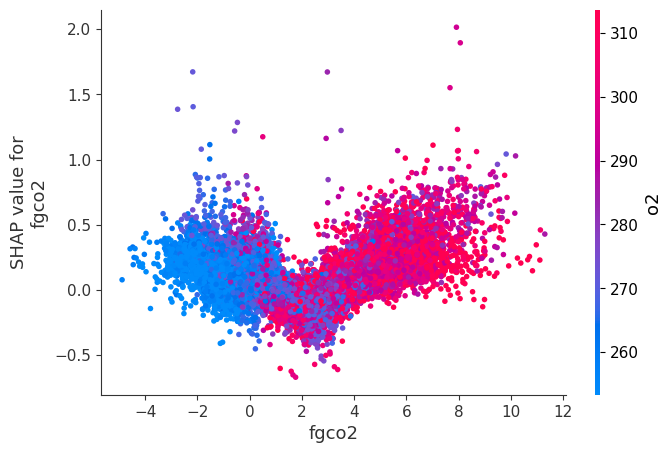

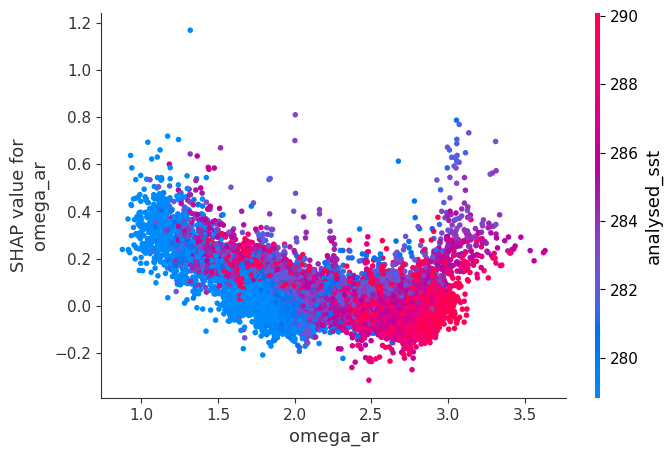

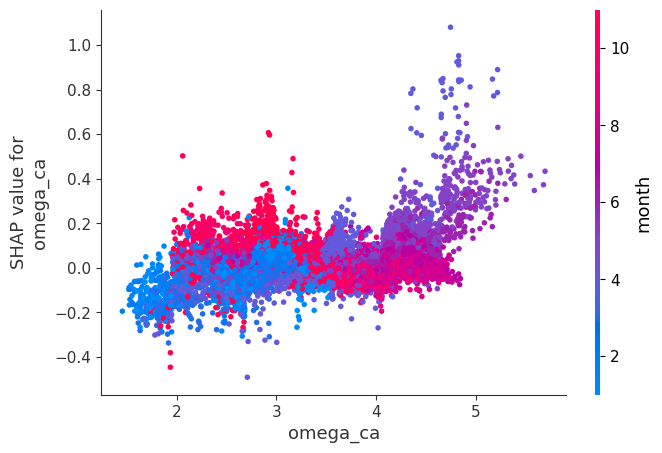

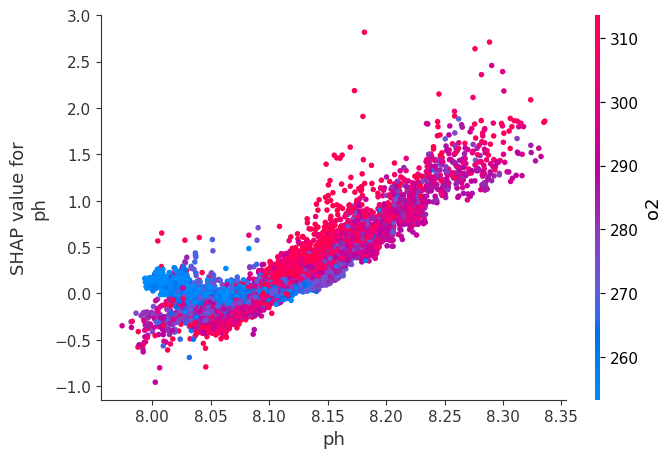

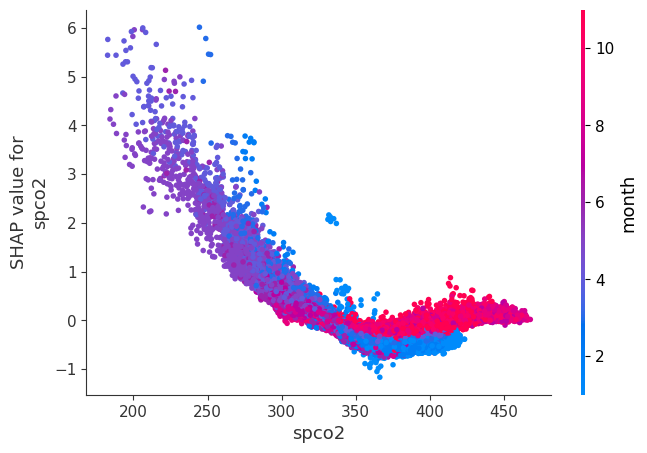

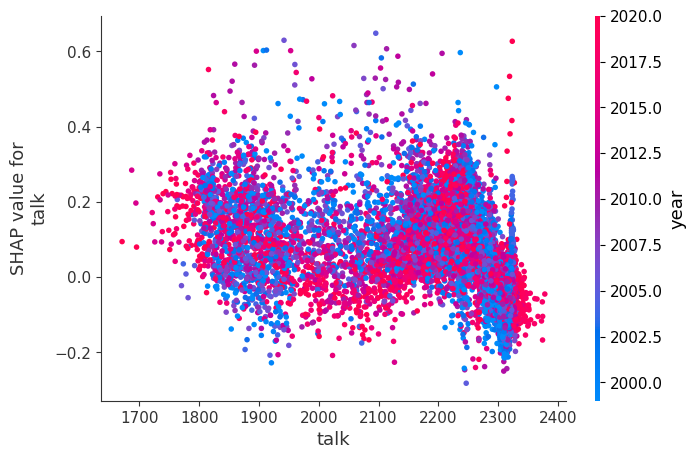

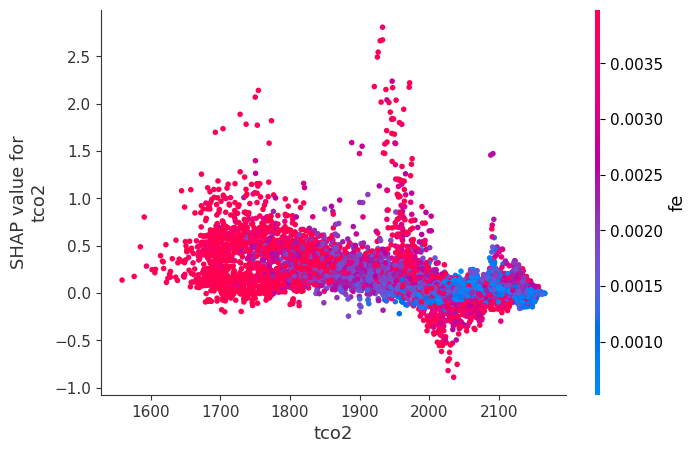

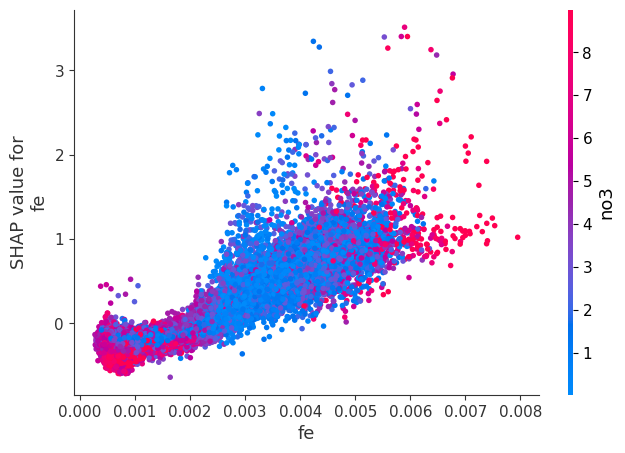

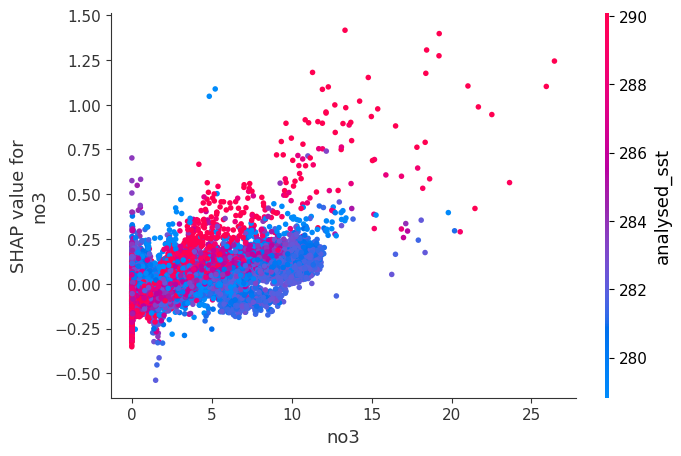

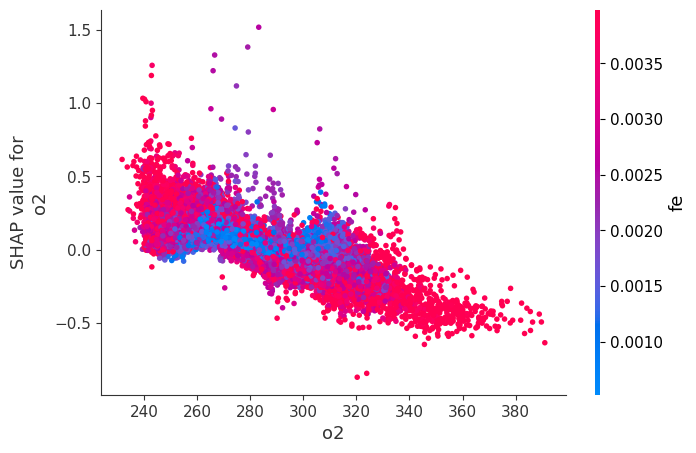

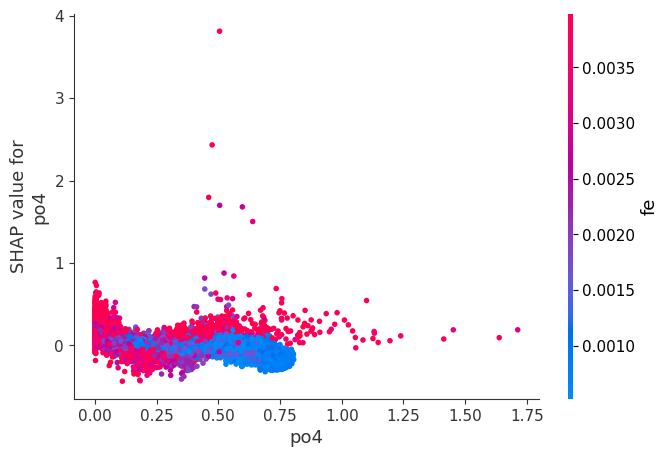

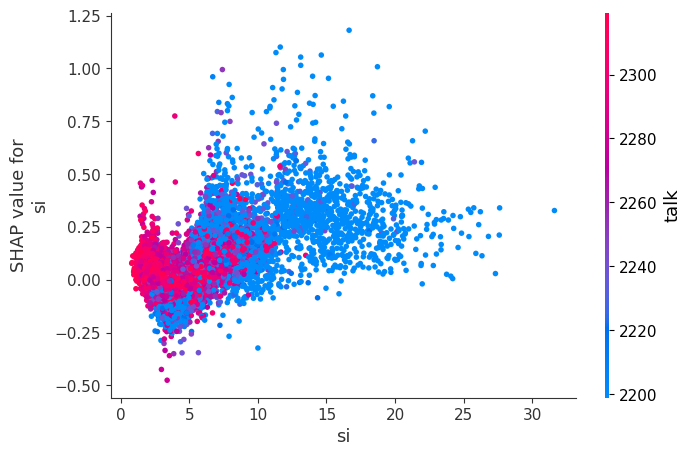

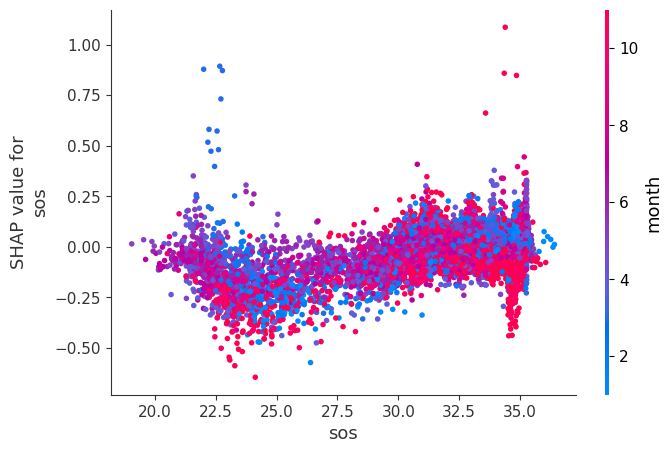

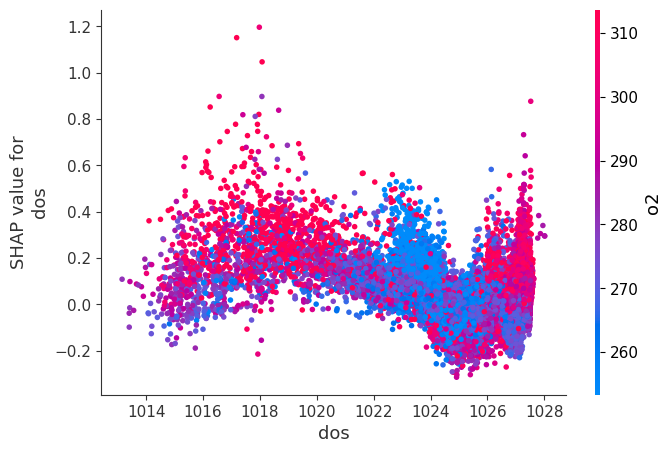

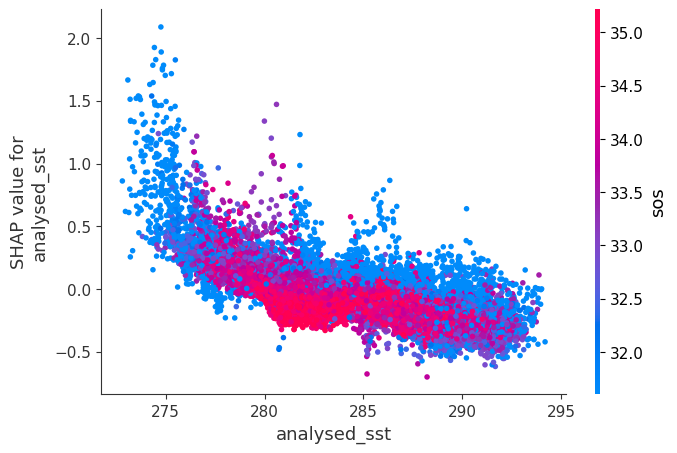

In [23]:
feat_names = list(X_train_test.columns)

for feat_name in feat_names:
    plot_shap_dependency_top_k(shap_values, X_train_test, feat_name, 1, True, shap_plots_path)
    gc.collect()

# Feature importance: permutation feature importance

https://christophm.github.io/interpretable-ml-book/feature-importance.html

https://mljar.com/blog/feature-importance-xgboost/

In [25]:
perm_importance = permutation_importance(xgb_best_model, X_train_test, y_train_test)
feat_names = list(X_train_test.columns)
feat_names

['latitude',
 'longitude',
 'year',
 'month',
 'deptho',
 'fgco2',
 'omega_ar',
 'omega_ca',
 'ph',
 'spco2',
 'talk',
 'tco2',
 'fe',
 'no3',
 'o2',
 'po4',
 'si',
 'sos',
 'dos',
 'analysed_sst']

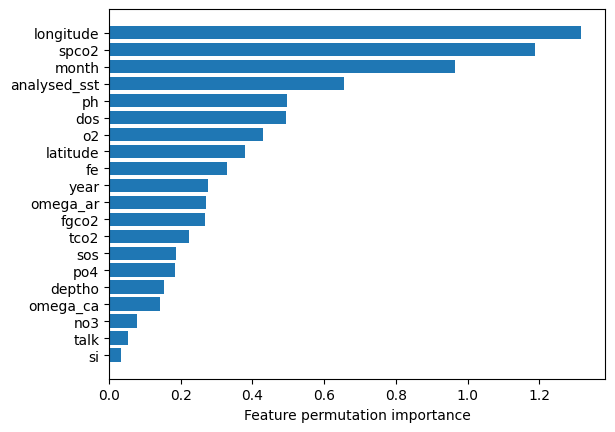

In [51]:
sorted_idx = perm_importance.importances_mean.argsort()
feat_names_sorted = [feat_names[i] for i in sorted_idx]
plt.barh(feat_names_sorted, perm_importance.importances_mean[sorted_idx])
plt.xlabel("Feature permutation importance")
plt.savefig(permutation_imp_plots_path + f"\\permutation_importance_plot.png")

In [52]:
def correlation_heatmap(X_train_feats, plots_save_path): 
    correlations = X_train_feats.corr()
    _, _ = plt.subplots(figsize = (12, 12))
    sns.heatmap(correlations, vmax = 1.0, center = 0, fmt = '.2f', cmap = "YlGnBu", square = True, linewidths = 0.5, annot = True, cbar_kws = {"shrink": .70})
    plt.savefig(plots_save_path + f"\\permutation_importance_heatmap.png")
    plt.show()

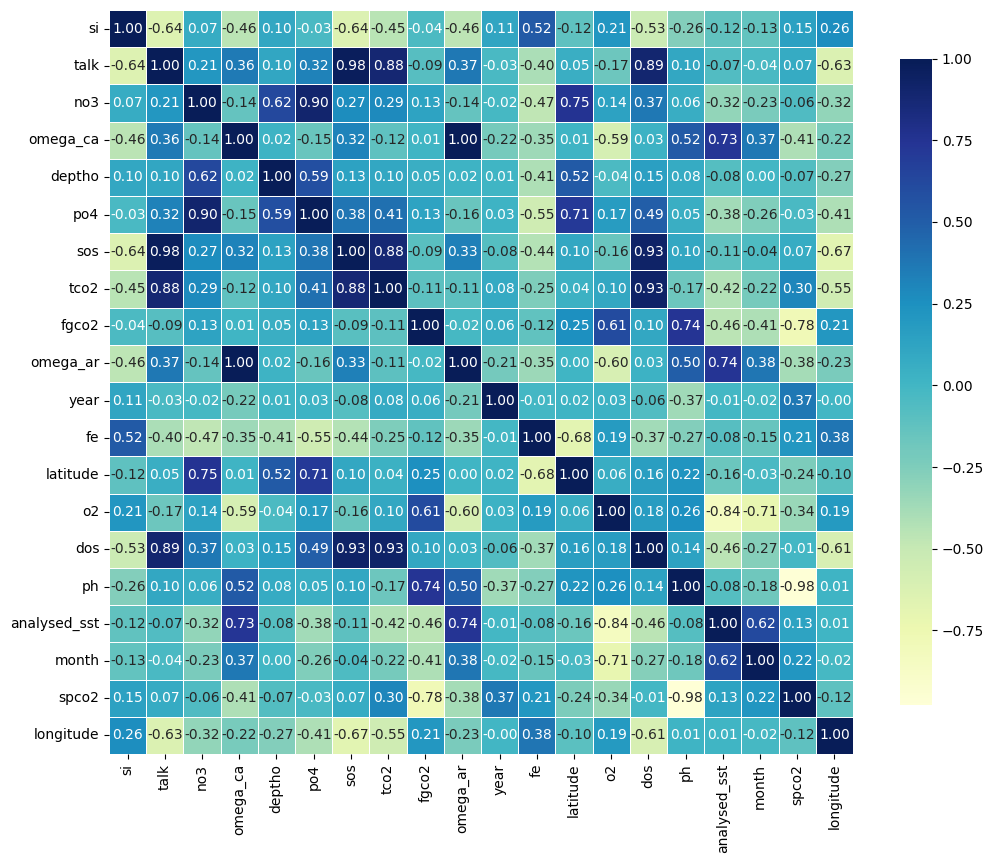

In [38]:
correlation_heatmap(X_train_train[feat_names_sorted], permutation_imp_plots_path)

# List of top 5 important features for XGBoost for each of the methods above

The ordering of the lists are [first, second, third, ...]

In [83]:
ALL_TOP_FEAT = []

In [84]:
time_features = {'month', 'year'}
position_features = {'longitude', 'latitude'}

def get_top_k_with_without_time_position(ordering, k, with_time, with_position):
    new_ordering = []
    for i in range(len(ordering)):
        append_element = True
        if (not with_time) and (ordering[i] in time_features):
            append_element = False
        if (not with_position) and (ordering[i] in position_features):
            append_element = False
        if append_element:
            new_ordering.append(ordering[i])
    ALL_TOP_FEAT.append(new_ordering[:k])
    return new_ordering[:k]   

In [85]:
def print_top_k_features(name_method, k, top_feat):
    print(f"{name_method} TOP {k} FEATURES")
    print(f"Top {k} (including position and time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=True, with_position=True))
    print(f"Top {k} (excluding position, including time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=True, with_position=False))
    print(f"Top {k} (including position, excluding time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=False, with_position=True))
    print(f"Top {k} (excluding position and time):")
    print(get_top_k_with_without_time_position(top_feat, k, with_time=False, with_position=False))
    print("")

### **"Normal" feature importance**

In [86]:
for x in top_features:
    print(x)

['weight', ['fgco2', 'si', 'fe', 'o2', 'deptho', 'no3', 'latitude', 'po4', 'talk', 'longitude', 'analysed_sst', 'year', 'ph', 'sos', 'tco2', 'dos', 'omega_ar', 'spco2', 'omega_ca', 'month']]
['gain', ['spco2', 'fe', 'month', 'deptho', 'longitude', 'ph', 'latitude', 'year', 'fgco2', 'analysed_sst', 'tco2', 'dos', 'si', 'po4', 'omega_ca', 'no3', 'omega_ar', 'talk', 'o2', 'sos']]
['cover', ['month', 'spco2', 'omega_ca', 'dos', 'sos', 'analysed_sst', 'ph', 'tco2', 'o2', 'po4', 'fe', 'deptho', 'talk', 'no3', 'fgco2', 'omega_ar', 'si', 'longitude', 'year', 'latitude']]


In [87]:
weight_top_feat = top_features[0][1]
gain_top_feat = top_features[1][1]
cover_top_feat = top_features[2][1]

In [88]:
print_top_k_features("WEIGHT", 5, weight_top_feat)
print_top_k_features("GAIN", 5, gain_top_feat)
print_top_k_features("COVER", 5, cover_top_feat)

WEIGHT TOP 5 FEATURES
Top 5 (including position and time):
['fgco2', 'si', 'fe', 'o2', 'deptho']
Top 5 (excluding position, including time):
['fgco2', 'si', 'fe', 'o2', 'deptho']
Top 5 (including position, excluding time):
['fgco2', 'si', 'fe', 'o2', 'deptho']
Top 5 (excluding position and time):
['fgco2', 'si', 'fe', 'o2', 'deptho']

GAIN TOP 5 FEATURES
Top 5 (including position and time):
['spco2', 'fe', 'month', 'deptho', 'longitude']
Top 5 (excluding position, including time):
['spco2', 'fe', 'month', 'deptho', 'ph']
Top 5 (including position, excluding time):
['spco2', 'fe', 'deptho', 'longitude', 'ph']
Top 5 (excluding position and time):
['spco2', 'fe', 'deptho', 'ph', 'fgco2']

COVER TOP 5 FEATURES
Top 5 (including position and time):
['month', 'spco2', 'omega_ca', 'dos', 'sos']
Top 5 (excluding position, including time):
['month', 'spco2', 'omega_ca', 'dos', 'sos']
Top 5 (including position, excluding time):
['spco2', 'omega_ca', 'dos', 'sos', 'analysed_sst']
Top 5 (excluding 

### **SHAP feature importance**

In [89]:
shap_top_feat = X_train_test.columns[np.argsort(np.abs(shap_values).mean(0))].to_list().copy()
shap_top_feat.reverse()
print(shap_top_feat)

['spco2', 'month', 'fe', 'longitude', 'ph', 'latitude', 'analysed_sst', 'year', 'fgco2', 'deptho', 'o2', 'talk', 'no3', 'dos', 'po4', 'tco2', 'omega_ar', 'si', 'sos', 'omega_ca']


In [90]:
print_top_k_features("SHAP", 5, shap_top_feat)

SHAP TOP 5 FEATURES
Top 5 (including position and time):
['spco2', 'month', 'fe', 'longitude', 'ph']
Top 5 (excluding position, including time):
['spco2', 'month', 'fe', 'ph', 'analysed_sst']
Top 5 (including position, excluding time):
['spco2', 'fe', 'longitude', 'ph', 'latitude']
Top 5 (excluding position and time):
['spco2', 'fe', 'ph', 'analysed_sst', 'fgco2']



### **Permutation feature importance**

In [91]:
perm_top_feat = feat_names_sorted.copy()
perm_top_feat.reverse()
print(perm_top_feat)

['longitude', 'spco2', 'month', 'analysed_sst', 'ph', 'dos', 'o2', 'latitude', 'fe', 'year', 'omega_ar', 'fgco2', 'tco2', 'sos', 'po4', 'deptho', 'omega_ca', 'no3', 'talk', 'si']


In [92]:
print_top_k_features("PERMUTATION", 5, perm_top_feat)

PERMUTATION TOP 5 FEATURES
Top 5 (including position and time):
['longitude', 'spco2', 'month', 'analysed_sst', 'ph']
Top 5 (excluding position, including time):
['spco2', 'month', 'analysed_sst', 'ph', 'dos']
Top 5 (including position, excluding time):
['longitude', 'spco2', 'analysed_sst', 'ph', 'dos']
Top 5 (excluding position and time):
['spco2', 'analysed_sst', 'ph', 'dos', 'o2']



### Features appearing in any of the top 5 lists above

In [93]:
ALL_TOP_FEAT

[['fgco2', 'si', 'fe', 'o2', 'deptho'],
 ['fgco2', 'si', 'fe', 'o2', 'deptho'],
 ['fgco2', 'si', 'fe', 'o2', 'deptho'],
 ['fgco2', 'si', 'fe', 'o2', 'deptho'],
 ['spco2', 'fe', 'month', 'deptho', 'longitude'],
 ['spco2', 'fe', 'month', 'deptho', 'ph'],
 ['spco2', 'fe', 'deptho', 'longitude', 'ph'],
 ['spco2', 'fe', 'deptho', 'ph', 'fgco2'],
 ['month', 'spco2', 'omega_ca', 'dos', 'sos'],
 ['month', 'spco2', 'omega_ca', 'dos', 'sos'],
 ['spco2', 'omega_ca', 'dos', 'sos', 'analysed_sst'],
 ['spco2', 'omega_ca', 'dos', 'sos', 'analysed_sst'],
 ['spco2', 'month', 'fe', 'longitude', 'ph'],
 ['spco2', 'month', 'fe', 'ph', 'analysed_sst'],
 ['spco2', 'fe', 'longitude', 'ph', 'latitude'],
 ['spco2', 'fe', 'ph', 'analysed_sst', 'fgco2'],
 ['longitude', 'spco2', 'month', 'analysed_sst', 'ph'],
 ['spco2', 'month', 'analysed_sst', 'ph', 'dos'],
 ['longitude', 'spco2', 'analysed_sst', 'ph', 'dos'],
 ['spco2', 'analysed_sst', 'ph', 'dos', 'o2']]

In [94]:
feat_appearing_in_top_5_lists = []
for x in ALL_TOP_FEAT:
    feat_appearing_in_top_5_lists.extend(x)

In [96]:
feat_appearing_in_top_5_lists = list(set(feat_appearing_in_top_5_lists))

In [98]:
print(feat_appearing_in_top_5_lists)
print(len(feat_appearing_in_top_5_lists))

['month', 'fgco2', 'latitude', 'analysed_sst', 'ph', 'dos', 'sos', 'si', 'longitude', 'o2', 'spco2', 'fe', 'omega_ca', 'deptho']
14
